<a href="https://colab.research.google.com/github/aofekiko/Cars196-E2E-CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cars196 E2E CNN

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/20733/logos/header.png?t=2020-05-14-08-44-45">

# Utils

## Import Libraries

In [ ]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID
!gdown --id 1Gr-a8q6ADgBvLnBNRZBmUYU9paMdnIQ8

## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

In [ ]:
%%capture
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True, with_info=True, data_dir=".")

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [ ]:
label_dic = pd.read_csv('labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

### Function - Plot Single Example
This function receives an image and a label and it will display it on a plot

In [ ]:
def plot_single_example(image, label, label_dic=label_dic):
  car_model_by_label = label_dic[str(label)]
  plt.title(f'Image Label: {car_model_by_label} ({label})')
  plt.imshow(image)

# Data Preprocessing

### Split Dataset
Train set contains 14567 examples<br>
Test set contains 1618 examples<br>
**It is allowed to change the ratio between the data sets.**


In [ ]:


[cars_train, cars_test] = tfds.load('Cars196',  split=["train[:90%]+test[:90%]", "train[90%:100%]+test[90%:100%]"], as_supervised=True, shuffle_files=True, data_dir=".")
print(len(cars_test))
print(len(cars_train))

1618
14567


Resize the data

In [ ]:
height, width = 256, 256  # Inputs divisable by 16 or 8 for better tensor core efficiency (https://www.tensorflow.org/guide/gpu_performance_analysis#1_enable_mixed_precision)
input_size = (height, width, 3)


# Parallel mapping to get rid of the input performance bottleneck and improve training performance
cars_train = cars_train.map(lambda x, y: (tf.image.resize_with_pad(x, height, width), y),num_parallel_calls=tf.data.AUTOTUNE)
cars_test = cars_test.map(lambda x, y: (tf.image.resize_with_pad(x, height, width), y),num_parallel_calls=tf.data.AUTOTUNE)

Split dataset into batches of 64

In [ ]:
batch_size = 64

cars_train = cars_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
cars_test = cars_test.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Model 1 - Base Model

## Define Model

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255, input_shape=(height, width, 3)),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), 
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(196, activation='softmax', dtype='float32') 
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       7

## Compile & Train

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30) # start_from_epoch=50 Missing feature in ts2.10, available in ts2.11+ # High patience for overfitting analysis


cp_callback = tf.keras.callbacks.ModelCheckpoint(
       filepath='./weights/cp-{epoch:04d}.ckpt',
        save_weights_only=True,
        save_freq='epoch')

#Sparse is better than normal cross entropy for training performance https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy' ,metrics=['accuracy']) 

history = model.fit(x = cars_train, validation_data = cars_test, epochs = 500, callbacks=[earlystop_callback, cp_callback], batch_size=batch_size, verbose=1)

Epoch 1/500
227/227 [==============================] - 30s 108ms/step - loss: 5.2716 - accuracy: 0.0066 - val_loss: 5.2315 - val_accuracy: 0.0088
Epoch 2/500
227/227 [==============================] - 24s 107ms/step - loss: 5.1527 - accuracy: 0.0132 - val_loss: 5.0723 - val_accuracy: 0.0188
Epoch 3/500
227/227 [==============================] - 24s 107ms/step - loss: 5.0322 - accuracy: 0.0206 - val_loss: 5.0538 - val_accuracy: 0.0200
Epoch 4/500
227/227 [==============================] - 24s 105ms/step - loss: 4.9295 - accuracy: 0.0281 - val_loss: 5.0141 - val_accuracy: 0.0194
Epoch 5/500
227/227 [==============================] - 24s 106ms/step - loss: 4.7986 - accuracy: 0.0416 - val_loss: 4.9801 - val_accuracy: 0.0262
Epoch 6/500
227/227 [==============================] - 24s 106ms/step - loss: 4.6294 - accuracy: 0.0604 - val_loss: 5.0711 - val_accuracy: 0.0338
Epoch 7/500
227/227 [==============================] - 24s 106ms/step - loss: 4.4391 - accuracy: 0.0821 - val_loss: 5.3756 -

## Visualize Loss & Accuracy

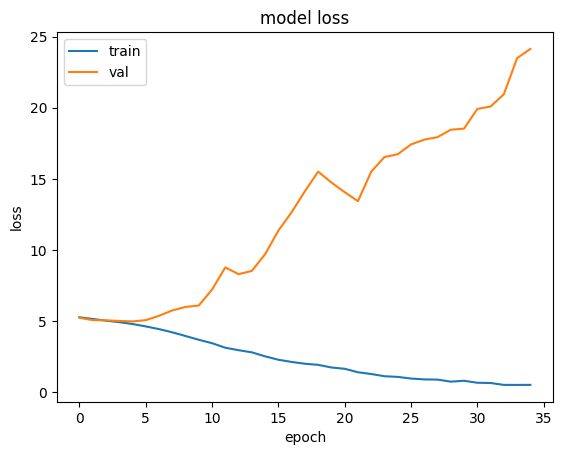

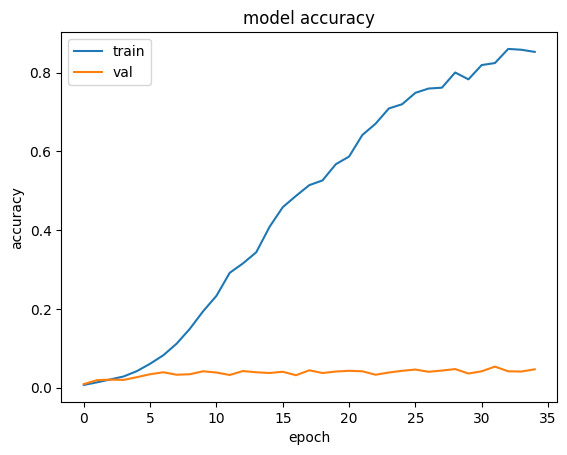

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Overall Model Results

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_hat = model.predict(cars_test, verbose=1)
predicted_class_indices= tf.argmax(y_hat, axis=1).numpy()
cars_test_labels = np.concatenate([y for x, y in cars_test], axis=0)
print(predicted_class_indices)
print(cars_test_labels)
print("Model accuracy:", accuracy_score(cars_test_labels, predicted_class_indices))
print("Classification Report")
print(classification_report(cars_test_labels, predicted_class_indices))

25/25 [==============================] - 1s 43ms/step
[  6  85 154 ... 104 166 128]
[ 51  75  89 ...  57 172 184]
Model accuracy: 0.006875
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        15
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        13
          14       0.05     

c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Model 2 - Augmentations

## Define Model

In [ ]:
model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255, input_shape=(height, width, 3)),
        tf.keras.layers.RandomFlip("horizontal"), 
        tf.keras.layers.RandomRotation(0.2), 
        tf.keras.layers.RandomContrast(0.2), 
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), 
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(196, activation='softmax', dtype='float32') 
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)    

## Compile & Train

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30) # start_from_epoch=50 Missing feature in ts2.10, available in ts2.11+ # High patience for overfitting analysis


cp_callback = tf.keras.callbacks.ModelCheckpoint(
       filepath='./weights/cp-{epoch:04d}.ckpt',
        save_weights_only=True,
        save_freq='epoch')

#Sparse is better than normal cross entropy for training performance https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy' ,metrics=['accuracy']) 

history = model.fit(x = cars_train, validation_data = cars_test, epochs = 500, callbacks=[earlystop_callback, cp_callback], batch_size=batch_size, verbose=1)

Epoch 1/500
227/227 [==============================] - 130s 564ms/step - loss: 5.2224 - accuracy: 0.0089 - val_loss: 5.1459 - val_accuracy: 0.0144
Epoch 2/500
227/227 [==============================] - 128s 566ms/step - loss: 5.1455 - accuracy: 0.0122 - val_loss: 5.1123 - val_accuracy: 0.0156
Epoch 3/500
227/227 [==============================] - 130s 573ms/step - loss: 5.0840 - accuracy: 0.0169 - val_loss: 5.0880 - val_accuracy: 0.0200
Epoch 4/500
227/227 [==============================] - 130s 571ms/step - loss: 5.0376 - accuracy: 0.0207 - val_loss: 5.0626 - val_accuracy: 0.0181
Epoch 5/500
227/227 [==============================] - 130s 573ms/step - loss: 4.9767 - accuracy: 0.0253 - val_loss: 5.0657 - val_accuracy: 0.0256
Epoch 6/500
227/227 [==============================] - 129s 567ms/step - loss: 4.9282 - accuracy: 0.0307 - val_loss: 5.0290 - val_accuracy: 0.0244
Epoch 7/500
227/227 [==============================] - 128s 566ms/step - loss: 4.8568 - accuracy: 0.0372 - val_loss: 4

## Visualize Loss & Accuracy

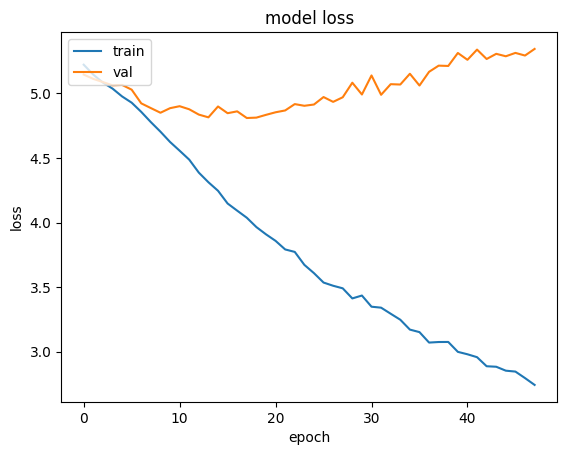

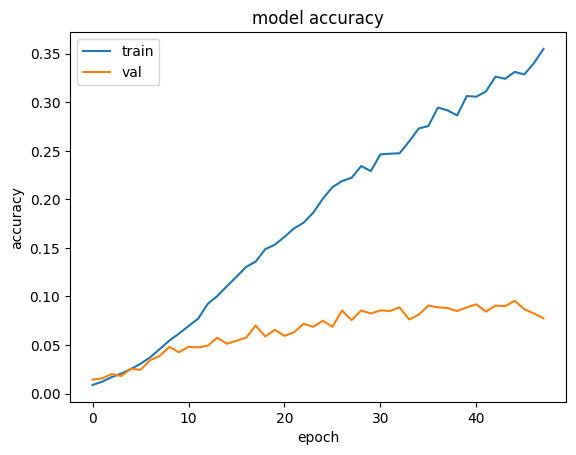

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Overall Model Results

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_hat = model.predict(cars_test, verbose=1)
predicted_class_indices= tf.argmax(y_hat, axis=1).numpy()
cars_test_labels = np.concatenate([y for x, y in cars_test], axis=0)
print("Model accuracy:", accuracy_score(cars_test_labels, predicted_class_indices))
print("Classification Report")
print(classification_report(cars_test_labels, predicted_class_indices))

25/25 [==============================] - 1s 37ms/step
Model accuracy: 0.008125
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.04      0.12      0.06         8
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         7
           6       0.08      0.17      0.11         6
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00        15
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00        11
          15       0.00      0.00 

c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Part 3 - Model overfitting mitigation

## Define Model

In [ ]:

# Mixed precision for better performance (https://www.tensorflow.org/guide/mixed_precision)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255, input_shape=(height, width, 3)),
        tf.keras.layers.RandomFlip("horizontal"), 
        tf.keras.layers.RandomRotation(0.2), 
        tf.keras.layers.RandomContrast(0.2), 
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(196, activation='softmax', dtype='float32') # Force datatype to be 32 due to enabling mixed precision (Nvidia AXP)
    ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_contrast_1 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)    

Define logging for tensorboard, used for GPU performance profiling and comparing the results of multiple models

In [ ]:


from datetime import datetime
from packaging import version

import os

run_name="Final"

logs = "logs/" + run_name + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs) # profile_batch=(64,128) Used to profile GPU optimization

#tf.config.optimizer.set_jit(True) enables auto-clustering XLA for better training performance https://www.tensorflow.org/xla#auto-clustering
#print(tf.config.optimizer.get_jit())
# Doesnt work on my local PC (TF 2.10 on windows incompatability)

## Compile & Train

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30) # start_from_epoch=50 Missing feature in ts2.10, available in ts2.11+ # High patience for overfitting analysis


cp_callback = tf.keras.callbacks.ModelCheckpoint(
       filepath='./weights/cp-{epoch:04d}.ckpt',
        save_weights_only=True,
        save_freq='epoch')

#Sparse is better than normal cross entropy for training performance https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy' ,metrics=['accuracy']) 

history = model.fit(x = cars_train, validation_data = cars_test, epochs = 500, callbacks=[earlystop_callback, tboard_callback, cp_callback], batch_size=batch_size, verbose=1)

Epoch 1/500
227/227 [==============================] - 133s 566ms/step - loss: 7.5634 - accuracy: 0.0092 - val_loss: 6.0270 - val_accuracy: 0.0081
Epoch 2/500
227/227 [==============================] - 144s 632ms/step - loss: 7.1845 - accuracy: 0.0172 - val_loss: 10.5600 - val_accuracy: 0.0137
Epoch 3/500
227/227 [==============================] - 137s 604ms/step - loss: 6.8944 - accuracy: 0.0199 - val_loss: 5.2219 - val_accuracy: 0.0262
Epoch 4/500
227/227 [==============================] - 126s 554ms/step - loss: 6.6632 - accuracy: 0.0246 - val_loss: 5.8935 - val_accuracy: 0.0406
Epoch 5/500
227/227 [==============================] - 127s 558ms/step - loss: 6.4016 - accuracy: 0.0312 - val_loss: 7.8559 - val_accuracy: 0.0206
Epoch 6/500
227/227 [==============================] - 136s 598ms/step - loss: 6.0504 - accuracy: 0.0400 - val_loss: 5.8983 - val_accuracy: 0.0194
Epoch 7/500
227/227 [==============================] - 135s 595ms/step - loss: 5.7316 - accuracy: 0.0447 - val_loss: 

## Save weights

In [ ]:
model.save_weights("cars_e2e_cnn_model_weights.h5")

## Visualize Loss & Accuracy

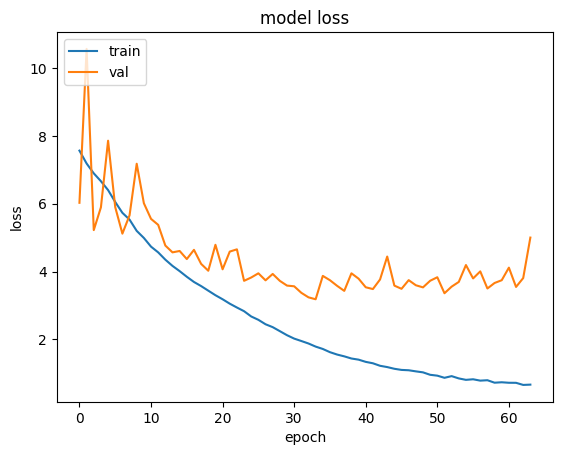

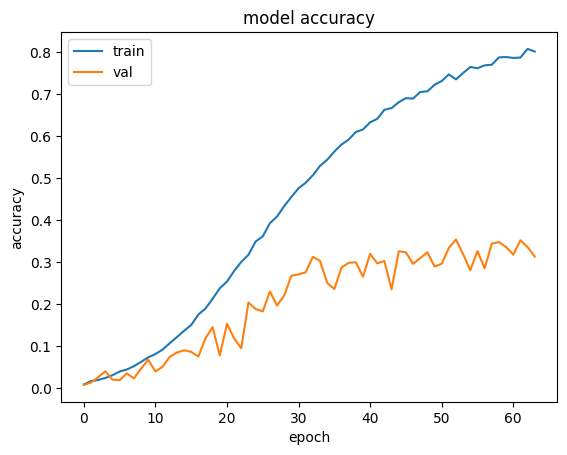

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Overall Model Results

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_hat = model.predict(cars_test, verbose=1)
predicted_class_indices= tf.argmax(y_hat, axis=1).numpy()
cars_test_labels = np.concatenate([y for x, y in cars_test], axis=0)
print("Model accuracy:", accuracy_score(cars_test_labels, predicted_class_indices))
print("Classification Report")
print(classification_report(cars_test_labels, predicted_class_indices))

25/25 [==============================] - 1s 39ms/step
Model accuracy: 0.31125
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.12      0.38      0.19         8
           2       0.12      0.50      0.19         6
           3       0.50      0.44      0.47         9
           4       0.00      0.00      0.00         3
           5       0.29      0.29      0.29         7
           6       0.08      0.17      0.11         6
           7       0.11      0.20      0.14        10
           8       0.24      0.64      0.35        11
           9       0.11      0.40      0.17         5
          10       0.62      0.53      0.57        15
          11       0.17      0.25      0.20         8
          12       0.07      0.60      0.12         5
          13       0.00      0.00      0.00        13
          14       0.29      0.18      0.22        11
          15       0.40      0.22  

c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\aofek\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Test environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


## Download model weights

In [ ]:
!gdown --id 1faCP54JRAKML0xXZ14IYUeaz_npAa1EW
!gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1faCP54JRAKML0xXZ14IYUeaz_npAa1EW
To: /content/cars_e2e_cnn_model_weights.h5
100% 9.56M/9.56M [00:00<00:00, 124MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID
To: /content/labels_dic.csv
100% 6.14k/6.14k [00:00<00:00, 9.33MB/s]


## Get car models labels and names

In [ ]:

label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

## Build model

Add new layers to the original model an change the output layer to the new amount of classes

In [ ]:
height, width = 256, 256
model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255, input_shape=(height, width, 3)),
        tf.keras.layers.RandomFlip("horizontal"), 
        tf.keras.layers.RandomRotation(0.2), 
        tf.keras.layers.RandomContrast(0.2), 
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5), 
        tf.keras.layers.Dense(196, activation='softmax', dtype='float32') # Force datatype to be 32 due to enabling mixed precision (Nvidia AXP)
    ])

## Load Model weights

In [ ]:
loaded_model = model.load_weights('/content/cars_e2e_cnn_model_weights.h5')

## Upload 224x224x3 image

In [ ]:
from google.colab import files

test_image = files.upload()

Saving serve_image.png to serve_image.png


## Predirct car type

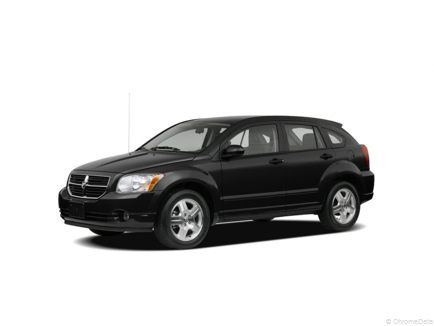

1/1 [==============================] - 0s 22ms/step
predicted class: 82
Dodge Caliber Wagon 2012


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

with Image.open ('/content/' + str(list(test_image.keys())[0])) as im:
    im.show()

img = cv2.imread('/content/' + str(list(test_image.keys())[0]))
img = cv2.resize(img,(height, width))
img = np.reshape(img,[1,height, width,3])
result = np.argmax(model.predict(img))

print("predicted class: " + str(result))

print(label_dic.get(str(result)))